# Librerías

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC

import os
import re

# Lectura de Datos

In [3]:
ruta = '/Users/gblasd/Documents/DataScience/02_SupervisedLearning/data/sentiment/' 
lst_files = os.listdir(ruta)
lst_files = [ f for f in lst_files if f[-3:] == 'csv' ];lst_files

['sentiment.csv']

In [4]:
df = pd.read_csv(ruta+lst_files[0]); df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
def clean_text(note_raw):
    nota = re.sub(r'<br\s*/?>', ' ', str(note_raw), flags=re.IGNORECASE)  # elimina <br>, <br/>, <br />
    nota = re.sub('[-,!?"\']', ' ', nota)  # elimina los caracteres -,!?
    nota = re.sub(r'\s+', ' ', nota, flags=re.I)  # elimina múltiples espacios
    nota = nota.lower()# convierte el texto a minúsculas
    return nota 

In [6]:
df["review_clean"] = df["review"].apply(clean_text); df

,review,sentiment,review_clean
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is a...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,i m going to have to disagree with the previou...


In [7]:
# Construyamos variables a partir de nuestros mensajes para hallar más patrones injestados
df['len_text_raw'] = df['review_clean'].str.len()
#url o teléfono 
df['n_urls'] = df.apply(lambda x: re.findall("http://", x["review_clean"]) + re.findall("https://", x["review_clean"]), axis=1).str.len()
# df['n_phone'] = df['review_clean'].map( lambda x: re.findall(r'\+?(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})', x)).str.len()
# cantidad de palabras
df['n_words'] = df['review_clean'].str.split(' ').str.len()
df['n_email'] = df['review_clean'].map( lambda x: re.findall(r'[a-z0-9\._-]+@[a-z0-9\._-]+', x.lower())).str.len()

df["n_dots"] = df["review_clean"].str.split(".").str.len() - 1
df["n_numeral"] = df["review_clean"].str.split("#").str.len() - 1

# df["n_lower_ratio_len"] = df["review_clean"].map(lambda x:sum(map(str.islower, x))) / df["len_text_raw"]
# df["n_upper_ratio_len"] = df["review_clean"].map(lambda x:sum(map(str.isupper, x))) / df["len_text_raw"]
df["n_letters"] = df["review_clean"].map(lambda x:sum(map(str.isalpha, x)))
df["n_lower_ratio_letters"] = df["review_clean"].map(lambda x:sum(map(str.islower, x))) / df["n_letters"]
# df["n_upper_ratio_letters"] = df["mensaje"].map(lambda x:sum(map(str.isupper, x))) / df["n_letters"]
df

,review,sentiment,review_clean,len_text_raw,n_urls,n_words,n_email,n_dots,n_numeral,n_letters,n_lower_ratio_letters
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,1702,0,310,0,26,0,1364,1.0
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. the filming tec...,949,0,160,0,6,0,781,1.0
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,892,0,169,0,6,0,712,1.0
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...,710,0,138,0,10,0,554,1.0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is a...,1258,0,228,0,15,0,1016,1.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,970,0,199,0,8,0,756,1.0
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...,612,0,111,0,5,0,497,1.0
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,1251,0,234,0,17,0,998,1.0
49998,I'm going to have to disagree with the previou...,negative,i m going to have to disagree with the previou...,1223,0,217,0,8,0,993,1.0


In [8]:
df.describe()

,len_text_raw,n_urls,n_words,n_email,n_dots,n_numeral,n_letters,n_lower_ratio_letters
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1270.494300,0.002580,235.516120,0.00160,13.010400,0.012800,1015.266340,1.000000
std,959.294167,0.054529,174.549299,0.04814,9.890968,0.390486,771.682932,0.000052
min,31.000000,0.000000,6.000000,0.00000,0.000000,0.000000,25.000000,0.988327
25%,681.000000,0.000000,129.000000,0.00000,7.000000,0.000000,541.000000,1.000000
50%,943.000000,0.000000,177.000000,0.00000,10.000000,0.000000,751.000000,1.000000
75%,1540.000000,0.000000,285.000000,0.00000,16.000000,0.000000,1232.000000,1.000000
max,13479.000000,3.000000,2506.000000,4.00000,175.000000,70.000000,10822.000000,1.000000


In [9]:
import nltk
from nltk.corpus import stopwords

In [10]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
sw=[i for i in stop];sw

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gblasd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


["he'll",
 'off',
 "we've",
 'm',
 'more',
 "shan't",
 "wasn't",
 's',
 "it'd",
 'they',
 "they'd",
 'wouldn',
 'to',
 "shouldn't",
 "it'll",
 "it's",
 'itself',
 'mightn',
 'under',
 'same',
 'through',
 "you're",
 'each',
 "won't",
 'on',
 'you',
 'while',
 'does',
 'both',
 "she'll",
 'had',
 'shan',
 'your',
 'i',
 'against',
 "we're",
 'can',
 "aren't",
 'as',
 'myself',
 'once',
 'd',
 'below',
 'himself',
 'further',
 'then',
 'do',
 'themselves',
 'hers',
 'no',
 'into',
 'was',
 'having',
 'yourself',
 'of',
 'there',
 'y',
 "couldn't",
 'when',
 'other',
 'between',
 'in',
 'because',
 'and',
 'have',
 'll',
 "needn't",
 'who',
 'should',
 're',
 'some',
 'nor',
 'her',
 'herself',
 'now',
 'is',
 'were',
 "should've",
 'all',
 'about',
 'are',
 'just',
 "they're",
 "we'd",
 'an',
 've',
 'which',
 'few',
 'so',
 'we',
 'ma',
 "don't",
 'weren',
 'before',
 'ours',
 "hadn't",
 'did',
 "doesn't",
 'me',
 'at',
 'such',
 'than',
 'own',
 'above',
 'be',
 'whom',
 'where',
 'am'

In [13]:
vect = CountVectorizer(stop_words=sw, ngram_range=(1, 150), min_df=.01,max_df=10); vect

CountVectorizer(max_df=10, min_df=0.01, ngram_range=(1, 150),
                stop_words=["he'll", 'off', "we've", 'm', 'more', "shan't",
                            "wasn't", 's', "it'd", 'they', "they'd", 'wouldn',
                            'to', "shouldn't", "it'll", "it's", 'itself',
                            'mightn', 'under', 'same', 'through', "you're",
                            'each', "won't", 'on', 'you', 'while', 'does',
                            'both', "she'll", ...])

In [ ]:
Xt = vect.fit_transform(df["review_clean"])

In [ ]:
df["sentiment"]

## Modelos de Clasificacion
### Regresion Logistica

In [8]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train)
ls_scores = cross_val_score(cv=4, estimator=logreg, X = X_train, y=y_train)
np.mean(ls_scores), np.std(ls_scores)


/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was pass

(np.float64(0.7805847744012229), np.float64(0.0024405794127657656))

In [9]:
# # Guardamos nuestro modelo que ya tiene un valor optimo
# import pickle

# with open('entregables/log_reg_modelo2.pkl', 'wb') as f:
#     pickle.dump(logreg, f)

In [10]:
tad_v["y_hat"] = logreg.predict(X_test);display(tad_v)
tad_v[["CUSTOMER_ID","y_hat"]].to_csv("entregables/RendonRosasRodolfo_DefaultPayment.csv")
tad_v[["CUSTOMER_ID","y_hat"]].to_csv("entregables/RendonRosasRodolfo_CreditScoring.csv")

,CUSTOMER_ID,Oportunidad_Aumento_Credito,d_promedio_deuda_2,d_promedio_deuda_3,d_promedio_deuda_4,d_BILL_AMT3_2,d_BILL_AMT3_3,d_BILL_AMT3_4,d_AMT5_Credito_Disponible_2,d_AMT5_Credito_Disponible_3,d_AMT5_Credito_Disponible_4,d_AGE_2,d_AGE_3,d_AGE_4,d_PAY_AMT5_2,d_PAY_AMT5_3,d_PAY_AMT5_4,d_Oportunidad_Aumento_Credito_2,d_Oportunidad_Aumento_Credito_3,d_Oportunidad_Aumento_Credito_4,d_Suma_Meses_Deuda_2,d_Suma_Meses_Deuda_3,d_Suma_Meses_Deuda_4,BILL_AMT1_Saldo_Favor,BILL_AMT2_Saldo_Favor,BILL_AMT3_Saldo_Favor,BILL_AMT4_Saldo_Favor,BILL_AMT5_Saldo_Favor,BILL_AMT6_Saldo_Favor,default.payment.next.month,w_d_Suma_Meses_Deuda_3,w_d_promedio_deuda_3,w_d_AMT5_Credito_Disponible_3,w_d_PAY_AMT5_3,w_Oportunidad_Aumento_Credito,w_BILL_AMT1_Saldo_Favor,w_d_AGE_4,y_hat
4790,16687,0,"(-2.001, 0.0]","(-0.5, 0.0]","(-0.833, 0.0]","(19833.0, 537543.0]","(42689.333, 537543.0]","(55730.0, 537543.0]","(-83400.001, 82730.0]","(-83400.001, 42470.0]","(-83400.001, 31133.0]","(20.999, 34.0]","(29.0, 38.0]","(28.0, 34.0]","(1500.0, 188715.0]","(2897.667, 188715.0]","(1500.0, 3840.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 33.0]","(-0.001, 1.0]","(-0.001, 2.0]",No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,NaN,0.61,0.71,-0.45,0.38,-0.54,0.03,0.19,0
4791,9926,0,"(-2.001, 0.0]","(-0.5, 0.0]","(-0.833, 0.0]","(19833.0, 537543.0]","(7400.333, 42689.333]","(19833.0, 55730.0]","(-83400.001, 82730.0]","(-83400.001, 42470.0]","(-83400.001, 31133.0]","(20.999, 34.0]","(20.999, 29.0]","(20.999, 28.0]","(-0.001, 1500.0]","(652.333, 2897.667]","(233.0, 1500.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 33.0]","(-0.001, 1.0]","(-0.001, 2.0]",No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,NaN,0.61,0.71,-0.45,-0.04,-0.54,0.03,-0.05,0
4792,29451,1,"(0.0, 5.5]","(0.0, 5.5]","(0.0, 5.5]","(19833.0, 537543.0]","(42689.333, 537543.0]","(55730.0, 537543.0]","(82730.0, 719428.0]","(42470.0, 158546.333]","(82730.0, 199976.0]","(20.999, 34.0]","(29.0, 38.0]","(28.0, 34.0]","(-0.001, 1500.0]","(-0.001, 652.333]","(-0.001, 233.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 33.0]","(1.0, 33.0]","(2.0, 33.0]",No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,NaN,-1.08,-1.17,0.08,-0.27,0.11,0.03,0.19,0
4793,14803,1,"(-2.001, 0.0]","(-2.001, -0.5]","(-0.833, 0.0]","(-9850.001, 19833.0]","(7400.333, 42689.333]","(2956.0, 19833.0]","(-83400.001, 82730.0]","(42470.0, 158546.333]","(31133.0, 82730.0]","(20.999, 34.0]","(20.999, 29.0]","(20.999, 28.0]","(1500.0, 188715.0]","(2897.667, 188715.0]","(3840.0, 188715.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 33.0]","(-0.001, 1.0]","(-0.001, 2.0]",No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,NaN,0.61,0.34,0.08,0.38,0.11,0.03,-0.05,0
4794,14536,1,"(0.0, 5.5]","(0.0, 5.5]","(0.0, 5.5]","(-9850.001, 19833.0]","(-9850.001, 7400.333]","(-9850.001, 2956.0]","(-83400.001, 82730.0]","(42470.0, 158546.333]","(31133.0, 82730.0]","(20.999, 34.0]","(20.999, 29.0]","(20.999, 28.0]","(-0.001, 1500.0]","(-0.001, 652.333]","(-0.001, 233.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 33.0]","(1.0, 33.0]","(2.0, 33.0]",No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,NaN,-1.08,-1.17,0.08,-0.27,0.11,0.03,-0.05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6660,15050,1,"(-2.001, 0.0]","(-0.5, 0.0]","(-0.833, 0.0]","(19833.0, 537543.0]","(42689.333, 537543.0]","(55730.0, 537543.0]","(82730.0, 719428.0]","(42470.0, 158546.333]","(82730.0, 199976.0]","(34.0, 79.0]","(38.0, 79.0]","(34.0, 41.0]","(1500.0, 188715.0]","(2897.667, 188715.0]","(1500.0, 3840.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 33.0]","(-0.001, 1.0]","(-0.001, 2.0]",No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,No A Favor,NaN,0.61,0.71,0.08,0.38,0.11,0.03,-0.00,0
6661,18104,1,"(0.0, 5.5]",

### Gradiente Descendiente Clasificador


In [11]:
sgdc = SGDClassifier()
sgdc.fit(X_train, y_train.values.ravel())
ls_medias = cross_val_score(estimator=sgdc, X=X_train, y = y_train.values.ravel(), cv = 4, n_jobs=-1, scoring="roc_auc")
np.mean(ls_medias), np.std(ls_medias)

(np.float64(0.7233231277740872), np.float64(0.013466267741549867))

In [12]:
tad_v["y_hat"] = sgdc.predict(X_test);tad_v 
tad_v[["CUSTOMER_ID","y_hat"]].to_csv("entregables/RendonRosasRodolfo_DefaultPayment.csv")
tad_v[["CUSTOMER_ID","y_hat"]].to_csv("entregables/RendonRosasRodolfo_CreditScoring.csv")

In [273]:
# # Guardamos nuestro modelo que ya tiene un valor optimo
# Mejor modelo de clasificacion
with open('entregables/sgdc_modelo1.pkl', 'wb') as f:
    pickle.dump(sgdc, f)

In [14]:
pd.DataFrame({"Variable":tad_v[cols_woe].columns.to_list(), "Coeficiente": sgdc.coef_.tolist()[0]}).sort_values(by = "Coeficiente", ascending=False)

,Variable,Coeficiente
3,w_d_PAY_AMT5_3,-0.09
6,w_d_AGE_4,-0.16
2,w_d_AMT5_Credito_Disponible_3,-0.21
4,w_Oportunidad_Aumento_Credito,-0.25
5,w_BILL_AMT1_Saldo_Favor,-0.27
0,w_d_Suma_Meses_Deuda_3,-0.44
1,w_d_promedio_deuda_3,-0.58


## Modelos con hiperparametros
### Modelo de Regresion Logistica

In [15]:
LogReg_Hyper = LogisticRegression(random_state=42)
param_grid = {
    'penalty': ['l1', 'l2','elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear'],  
    'l1_ratio': [x for x in range(1, 100)] + [y/10 for y in range(10)],
    'class_weight': [None, 'balanced']
}
LogReg_Hyper.fit(X_train, y_train)
ls_medias = cross_val_score(estimator=LogReg_Hyper, X=X_train, y = y_train, cv = 4, n_jobs=-1)
np.mean(ls_medias), np.std(ls_medias)

/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was pass

(np.float64(0.7805847744012229), np.float64(0.0024405794127657656))

In [16]:
clf = RandomizedSearchCV(LogReg_Hyper, param_grid, cv=4, error_score=-1000, n_jobs=-1, scoring="roc_auc", verbose=2, random_state=42)
clf.fit(X_train, y_train)
print("Best score: " + str(clf.best_score_))
summary = pd.DataFrame(clf.cv_results_)
summary.sort_values(by = "rank_test_score")
{"model": clf.best_estimator_, "score": clf.best_score_}

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END C=0.1, class_weight=None, l1_ratio=69, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=None, l1_ratio=69, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=None, l1_ratio=69, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=None, l1_ratio=69, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, l1_ratio=50, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, l1_ratio=50, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.1, class_weight=balanced, l1_ratio=50, penalty=elasticnet, solver=liblinear; total t

/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ro

[CV] END C=0.1, class_weight=balanced, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=10, class_weight=None, l1_ratio=70, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, l1_ratio=70, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, l1_ratio=47, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, l1_ratio=47, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, l1_ratio=86, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, l1_ratio=47, penalty=l2, solver=liblinear; total time=   0.0s[CV] END C=0.1, class_weight=balanced, l1_ratio=86, penalty=elasticnet, solver=liblinear; total time=   0.0s

[CV] END C=0.1, class_weight=balanced, l1_ratio=86, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, l1_ratio=86, penalty=elasticnet, s

/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
36 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to -1000.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/rodolfo/Entornos/Gen28_RRR/lib/python3.12/site-packages/sklearn/base.py", line 436, in _validate_params
    valida

{'model': LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.5,
                    random_state=42, solver='liblinear'),
 'score': np.float64(0.7429341199197277)}

In [17]:
best_LogReg = clf.best_estimator_

In [18]:
tad_v["y_hat"] = best_LogReg.predict(X_test)
tad_v[["CUSTOMER_ID","y_hat"]].to_csv("entregables/RendonRosasRodolfo_DefaultPayment.csv")
tad_v[["CUSTOMER_ID","y_hat"]].to_csv("entregables/RendonRosasRodolfo_CreditScoring.csv")
tad_v[["CUSTOMER_ID","y_hat"]].to_csv("entregables/RendonRosasRodolfo_CreditScoringPP.csv")

In [19]:
# Guardamos nuestro modelo que ya tiene un valor optimo

# with open('entregables/hyper_LogReg_modelo3.pkl', 'wb') as f: #modelo 3 ha sido el mejor
#     pickle.dump(best_LogReg, f)

In [20]:
pd.DataFrame({"Variable":tad_v[cols_woe].columns.to_list(), "Coeficiente": best_LogReg.coef_.tolist()[0]}).sort_values(by = "Coeficiente", ascending=False)

,Variable,Coeficiente
4,w_Oportunidad_Aumento_Credito,-0.19
2,w_d_AMT5_Credito_Disponible_3,-0.37
6,w_d_AGE_4,-0.42
1,w_d_promedio_deuda_3,-0.45
0,w_d_Suma_Meses_Deuda_3,-0.55
3,w_d_PAY_AMT5_3,-0.72
5,w_BILL_AMT1_Saldo_Favor,-1.21


# Credit Scoring

## Modelo SGDC 

In [21]:
sgdc.predict(tad_v[cols_woe])#[:,1]

array([0, 0, 1, ..., 0, 0, 0])

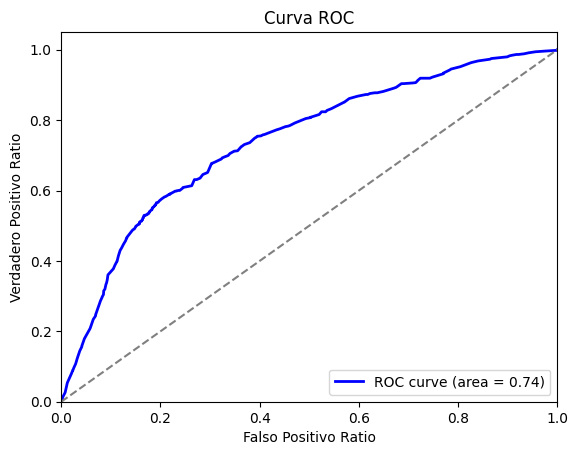

In [22]:
# Calcular la curva ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = tad[tgt]
y_scores = sgdc.decision_function(tad[cols_woe])#[:,1]

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Falso Positivo Ratio")
plt.ylabel("Verdadero Positivo Ratio")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

In [23]:
from sklearn.metrics import accuracy_score,confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score
def metricas2(model, Xv, yv, tgt_col, cols_validate):    
    Xv_used = Xv[cols_validate] if cols_validate is not None else Xv
    y_true = yv[tgt_col]

    # Predicciones
    y_pred_proba = model.decision_function(Xv_used)
    y_pred = model.predict(Xv_used)

    # Métricas
    print(f"ROC AUC:        {roc_auc_score(y_true, y_pred_proba):.3f}")
    print(f"Accuracy:       {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision:      {precision_score(y_true, y_pred):.3f}")
    print(f"Recall:         {recall_score(y_true, y_pred):.3f}")
    print(f"F1-Score:       {f1_score(y_true, y_pred):.3f}")
    print("\nMatriz de Confusión:")
    print(confusion_matrix(y_true, y_pred))

In [24]:
metricas2(sgdc , X_train, y_train, tgt, cols_woe)

ROC AUC:        0.739
Accuracy:       0.770
Precision:      0.472
Recall:         0.506
F1-Score:       0.488

Matriz de Confusión:
[[3164  588]
 [ 513  525]]


### Transformación a Scoring (targeta de puntos)

In [248]:

def scoring_card(PDO, base_odds, base_score, b, model):
    factor = PDO / np.log(2)

    offset = base_score - factor * np.log( base_odds)

    print(f"Factor: {factor}, Offset: {offset}")

    betas = model.coef_[0].tolist()
    beta0 = model.intercept_[0]

    n = len(betas)
    # Creacion de puntos
    for v, beta in zip(cols_woe, betas):

        print(f"Variable: {v}, con beta: {beta}")

        tad[f'pts_{v}'] = np.ceil(  ( -tad[v] * beta+beta0 / n  ) * factor + offset / n )
        tad_v[f'pts_{v}'] = np.ceil(  ( -tad_v[v] * beta+beta0 / n  ) * factor + offset / n )
    
    varp = tad.filter(like='pts').columns.tolist()

    tad['score'] = tad[varp].sum(axis=1)
    tad_v['score'] = tad_v[varp].sum(axis=1)
    lst = []

    for vi, vp in zip( [v[2:] for v in cols_woe] , varp):
        print(vi , " ----- " , vp)

        aux = tad[[vi,"w_"+vi,vp]].drop_duplicates()
        aux = aux.sort_values( by = vi , ascending = True ).reset_index(drop=True)
        # aux.columns = ['atributo', 'woe_val','puntos']
        # aux['característica'] = vi
        # display(aux)
        lst.append(aux)
    scorecard = pd.concat(lst,axis=1) #,ignore_index=True
    tad['r_score'] = pd.cut(tad['score'],bins=b,include_lowest=True).astype(str)
    aux     = tad[['r_score','default.payment.next.month']].copy()
    aux['n']= 1
    aux= aux.pivot_table(index='r_score',columns='default.payment.next.month',values='n',aggfunc='sum')
    return (aux, scorecard)
    


In [237]:
tad["score"].describe()

count   4,790.00
mean      -69.68
std        30.26
min      -131.00
25%       -81.00
50%       -55.00
75%       -51.00
max       -32.00
Name: score, dtype: float64

In [254]:

PDO        = 50  #Puntos para duplicar las probabilidades
base_odds  = 1 #"varianza"
base_score = 250 #"media"

b = 9 # numero bines

scoring_card(PDO, base_odds, base_score, b, sgdc)[0]

Factor: 72.13475204444818, Offset: 250.0
Variable: w_d_Suma_Meses_Deuda_3, con beta: -0.4376997211221774
Variable: w_d_promedio_deuda_3, con beta: -0.5770667526163471
Variable: w_d_AMT5_Credito_Disponible_3, con beta: -0.20629203665868884
Variable: w_d_PAY_AMT5_3, con beta: -0.08734744375121511
Variable: w_Oportunidad_Aumento_Credito, con beta: -0.24602605671609604
Variable: w_BILL_AMT1_Saldo_Favor, con beta: -0.27319145548623597
Variable: w_d_AGE_4, con beta: -0.16431502608198276
d_Suma_Meses_Deuda_3  -----  pts_w_d_Suma_Meses_Deuda_3
d_promedio_deuda_3  -----  pts_w_d_promedio_deuda_3
d_AMT5_Credito_Disponible_3  -----  pts_w_d_AMT5_Credito_Disponible_3
d_PAY_AMT5_3  -----  pts_w_d_PAY_AMT5_3
Oportunidad_Aumento_Credito  -----  pts_w_Oportunidad_Aumento_Credito
BILL_AMT1_Saldo_Favor  -----  pts_w_BILL_AMT1_Saldo_Favor
d_AGE_4  -----  pts_w_d_AGE_4


default.payment.next.month,0,1
r_score,,
"(119.81299999999999, 140.667]",353,374
"(140.667, 161.333]",234,149
"(161.333, 182.0]",1,2
"(182.0, 202.667]",4,3
"(202.667, 223.333]",90,37
"(223.333, 244.0]",42,22
"(244.0, 264.667]",1060,232
"(264.667, 285.333]",1873,215
"(285.333, 306.0]",95,4


## Modelo Regresion Logistica con Hiperparametros

In [256]:
best_LogReg.predict_proba

<bound method LogisticRegression.predict_proba of LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.5,
                   random_state=42, solver='liblinear')>

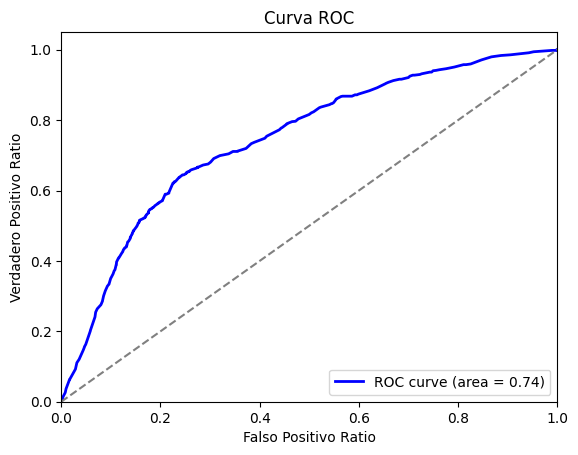

In [257]:
# Calcular la curva ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = tad[tgt]
y_scores = best_LogReg.predict_proba(tad[cols_woe])[:,1]

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Falso Positivo Ratio")
plt.ylabel("Verdadero Positivo Ratio")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

In [258]:
metricas2(best_LogReg , X_train, y_train, tgt, cols_woe)

ROC AUC:        0.744
Accuracy:       0.747
Precision:      0.437
Recall:         0.572
F1-Score:       0.495

Matriz de Confusión:
[[2986  766]
 [ 444  594]]


In [ ]:
PDO        = 25  #Puntos para duplicar las probabilidades
base_odds  = 1 #"varianza"
base_score = 400 #"media"

b = 9 # numero bines

scoring_card(PDO, base_odds, base_score, b, best_LogReg)[0]

Factor: 36.06737602222409, Offset: 400.0
Variable: w_d_Suma_Meses_Deuda_3, con beta: -0.5521631496869934
Variable: w_d_promedio_deuda_3, con beta: -0.45126389793373844
Variable: w_d_AMT5_Credito_Disponible_3, con beta: -0.3695288557110034
Variable: w_d_PAY_AMT5_3, con beta: -0.7231337490875606
Variable: w_Oportunidad_Aumento_Credito, con beta: -0.1872723723751378
Variable: w_BILL_AMT1_Saldo_Favor, con beta: -1.2056741849187549
Variable: w_d_AGE_4, con beta: -0.4218537943233265
d_Suma_Meses_Deuda_3  -----  pts_w_d_Suma_Meses_Deuda_3
d_promedio_deuda_3  -----  pts_w_d_promedio_deuda_3
d_AMT5_Credito_Disponible_3  -----  pts_w_d_AMT5_Credito_Disponible_3
d_PAY_AMT5_3  -----  pts_w_d_PAY_AMT5_3
Oportunidad_Aumento_Credito  -----  pts_w_Oportunidad_Aumento_Credito
BILL_AMT1_Saldo_Favor  -----  pts_w_BILL_AMT1_Saldo_Favor
d_AGE_4  -----  pts_w_d_AGE_4


default.payment.next.month,0,1
r_score,,
"(332.839, 350.778]",36.00,38.00
"(350.778, 368.556]",408.00,392.00
"(368.556, 386.333]",172.00,109.00
"(386.333, 404.111]",175.00,73.00
"(404.111, 421.889]",657.00,151.00
"(421.889, 439.667]","1,731.00",245.00
"(439.667, 457.444]",530.00,28.00
"(457.444, 475.222]",31.00,NaN
"(475.222, 493.0]",12.00,2.00
